# Eldritch Name Generation for Fun and Profit

This notebook is intended to be an easy intoroduction to the text generation techniques on a task of creating new names for the Eldritch beings. We will try to solve this task with a bigram model, an n-gram model, and a transformer model.

In [1]:
# just some imports and options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)
sns.set_theme(style='darkgrid', palette='muted', font='monospace')

### Get Training Data

First, we need some training data, which we will obtain from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Great_Old_Ones). It's not much but we'll work with what we have.

In [2]:
# retrieve and process a list of eldritch names from https://en.wikipedia.org/wiki/List_of_Great_Old_Ones

# retrieve the original data
url = 'https://en.wikipedia.org/wiki/List_of_Great_Old_Ones'
beings = pd.read_html(url, match='Name')[0]

# preprocess data, remove references and non-english characters
names = beings['Name'].str.lower()
names = names.str.replace('\[(.*?)\]', '', regex=True)
names = names.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# split paired names in two, i.e. Nug and Yeb -> [Nug,Yeb]
names = names.str.split(' and ')
names = names.explode(ignore_index=True)
names = names.str.split(' & ')
names = names.explode(ignore_index=True)

# remove non-eldritch names
to_remove = ['the color', 'god of the red flux', 'the green god',
             'the unimaginable horror', 'the worm that gnaws in the night']
names = names[~names.isin(to_remove)]

# sort and reset index
names = names.sort_values()
names = names.reset_index(drop=True)

# display 10 first names
print(names.head(10))

0          'ymnar
1         abholos
2           alala
3       ammutseba
4    amon-gorloth
5     aphoom-zhah
6    apocolothoth
7         arwassa
8    atlach-nacha
9          ayi'ig
Name: Name, dtype: object


Next, we form a single string of text from which we learn the patterns in the letter arrangement.

In [3]:
# concatenate training data into a single string
training_data = '.' + '.'.join(names.tolist()) + '.'
print(f'training_data = {training_data}')

training_data = .'ymnar.abholos.alala.ammutseba.amon-gorloth.aphoom-zhah.apocolothoth.arwassa.atlach-nacha.ayi'ig.aylith.b'gnu-thun.baoht z'uqqa-mogg.basatan.bokrug.bugg-shash.byagoona.byatis.chaugnar faugn.coatlicue.coinchenn.crom cruach.cthaat.cthaeghya.cthugha.cthulhu.cthylla.ctoggha.cyaegha.cynothoglys.dhumin.dygra.dythalla.dzewa.ei'lor.eihort.etepsed egnis.ghadamon.ghatanothoa.ghisguth.gi-hoveg.gla'aki.gleeth.gloon.gobogeg.gog-hoor.gol-goroth.golothess.groth-golka.gtuhanai.gur'la-ya.gurathnaka.gwarloth.gzxtyos.h'chtelegoth.haiogh-yai.han.hastalyk.hastur.hnarqu.hziulquoigmnzhah.idh-yaa.inpesca.iod.istasha.ithaqua.janai'ngo.juk-shabb.k'nar'st.kaalut.kag'naru of the air.kassogtha.kaunuzoth.khal'kru.klosmiebhyx.krang.kthaw'keth.kurpannga.lam.lexur'iga-serr'roth.lloigor.lythalia.m'basui gwandu.m'nagalah.mappo no ryujin.mnomquah.mordiggian.mormo.mortllgh.mynoghra.nctolhu.nctosa.ngirrth'lu.northot.nssu-ghahnb.nug.nyaghoggua.nycrama.nyogtha.ob'mbu.oorn.othuum.othuyeg.perse.pharol.poseidon

Now that we have a training data, we almost can start learning.
However, we still have one issue to address: language models don't work necessarily with text --- they work with *tokens*, which represent small units of text --- words, subwords, letters, or something else.
The choice of tokenization depends on many factors, including the task, the training data, and the model.

For simplicity, in this project we chose the per-character tokenization.
That is, each letter and symbol in the training data is going to be represented by a token.
Thus we have 30 tokens, consisting of 26 letters a--z, dash "-", apostrophe "'", space " ", and a dot symbol "." marking the beginning/end of a name.

In [4]:
# map to convert symbols to tokens
symbol_to_token = {'.': 0, ' ': 1, '-': 2, '\'': 3}\
                | {chr(i+97): i+4  for i in range(26)}
print(f'symbol_to_token = {symbol_to_token}')

# map to convert tokens to symbols
token_to_symbol = {s: t for t, s in symbol_to_token.items()}
print(f'token_to_symbol = {token_to_symbol}')

# determine vocabulary size
VOCAB_SIZE = len(symbol_to_token)

symbol_to_token = {'.': 0, ' ': 1, '-': 2, "'": 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'w': 26, 'x': 27, 'y': 28, 'z': 29}
token_to_symbol = {0: '.', 1: ' ', 2: '-', 3: "'", 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z'}


Next, we encode the training data. As we're working with tokens, we need to establish a way to translate symbols into tokens and vice verca.

In [5]:
def encode_symbol(symbol):
    """Convert symbol to a token."""
    return symbol_to_token.get(symbol.lower(), 1)

def decode_token(token):
    """Convert token to a symbol."""
    return token_to_symbol.get(token, ' ')

def encode(text):
    """Return the list of tokens that represent a string."""
    return list(map(encode_symbol, text))

def decode(tokens):
    """Return the string represented by the list of tokens."""
    return ''.join(map(decode_token, tokens))

# validate encoding/decoding
assert training_data == decode(encode(training_data)),\
       'Training data is changed after encoding/decoding.'

# encode training data
data_encoding = encode(training_data)
print(f'data_encoding = {data_encoding}')

data_encoding = [0, 3, 28, 16, 17, 4, 21, 0, 4, 5, 11, 18, 15, 18, 22, 0, 4, 15, 4, 15, 4, 0, 4, 16, 16, 24, 23, 22, 8, 5, 4, 0, 4, 16, 18, 17, 2, 10, 18, 21, 15, 18, 23, 11, 0, 4, 19, 11, 18, 18, 16, 2, 29, 11, 4, 11, 0, 4, 19, 18, 6, 18, 15, 18, 23, 11, 18, 23, 11, 0, 4, 21, 26, 4, 22, 22, 4, 0, 4, 23, 15, 4, 6, 11, 2, 17, 4, 6, 11, 4, 0, 4, 28, 12, 3, 12, 10, 0, 4, 28, 15, 12, 23, 11, 0, 5, 3, 10, 17, 24, 2, 23, 11, 24, 17, 0, 5, 4, 18, 11, 23, 1, 29, 3, 24, 20, 20, 4, 2, 16, 18, 10, 10, 0, 5, 4, 22, 4, 23, 4, 17, 0, 5, 18, 14, 21, 24, 10, 0, 5, 24, 10, 10, 2, 22, 11, 4, 22, 11, 0, 5, 28, 4, 10, 18, 18, 17, 4, 0, 5, 28, 4, 23, 12, 22, 0, 6, 11, 4, 24, 10, 17, 4, 21, 1, 9, 4, 24, 10, 17, 0, 6, 18, 4, 23, 15, 12, 6, 24, 8, 0, 6, 18, 12, 17, 6, 11, 8, 17, 17, 0, 6, 21, 18, 16, 1, 6, 21, 24, 4, 6, 11, 0, 6, 23, 11, 4, 4, 23, 0, 6, 23, 11, 4, 8, 10, 11, 28, 4, 0, 6, 23, 11, 24, 10, 11, 4, 0, 6, 23, 11, 24, 15, 11, 24, 0, 6, 23, 11, 28, 15, 15, 4, 0, 6, 23, 18, 10, 10, 11, 4, 0, 6, 28, 4,

### Bigram Model

Now we're ready to implement our first model --- a [bigram](https://en.wikipedia.org/wiki/Bigram) model.\
We first compute a bigram matrix, which represents how often each bigram appears in the training data.

In [6]:
# compute bigram matrix by computing bigram frequency in the training data
bigrams = np.zeros((VOCAB_SIZE,VOCAB_SIZE), dtype=int)
for i in range(len(data_encoding)-1):
    bigrams[data_encoding[i], data_encoding[i+1]] += 1
    
# optionally, smooth the bigram matrix
# this allows to sample bigrams that are not in the training data
bigrams += 1

# disable combinations that should not appear
# in our case it is sequential non-letter symbols
bigrams[:4,:4] = 0

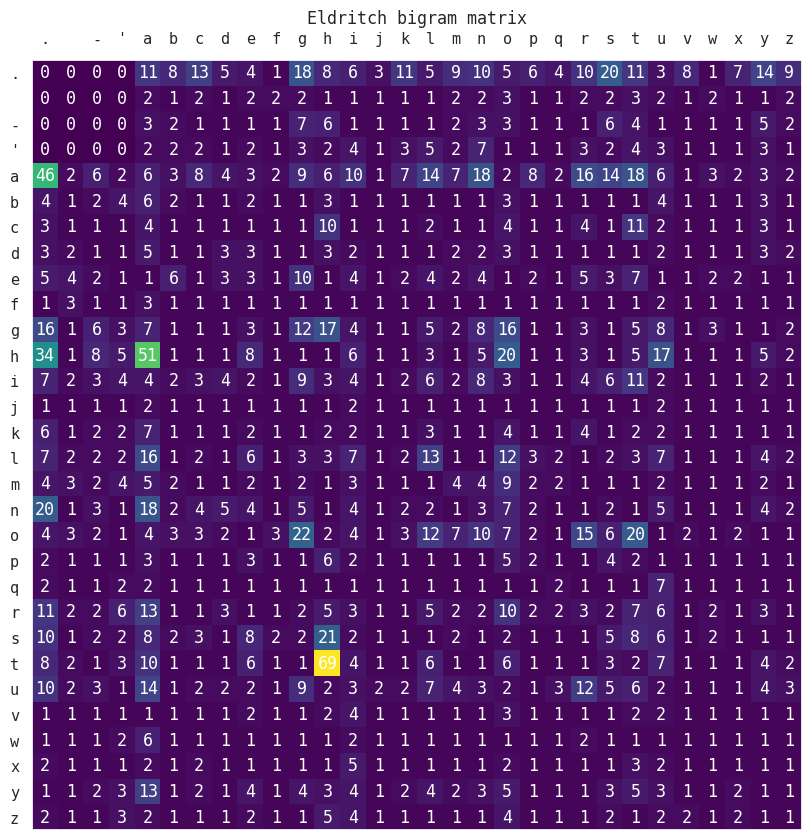

In [7]:
# visualize bigram matrix
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(bigrams, cmap='viridis')

# annotate each cell with bigram count
for i in range(VOCAB_SIZE):
    for j in range(VOCAB_SIZE):
        text = ax.text(j, i, bigrams[i,j], ha="center", va="center", color="w")

# configure axis
ax.set_title('Eldritch bigram matrix')
_ = ax.set_xticks(range(VOCAB_SIZE), symbol_to_token.keys())
_ = ax.set_yticks(range(VOCAB_SIZE), symbol_to_token.keys())
ax.tick_params(top=False, bottom=False, left=False, right=False)
ax.grid(None)

Now, that the bigram matrix is computed, an Eldritch name can be generated by sampling from this matrix.

In [8]:
def generate_name_bigram(random_seed=None):
    """Generate an Eldritch name with the bigram model."""
    if random_seed is not None:
        np.random.seed(random_seed)

    # sample the name starting with the start token '.' 
    name = [0]
    while True:
        prob = bigrams[name[-1]] / bigrams[name[-1]].sum()
        name.append(np.random.choice(range(VOCAB_SIZE), p=prob))
        # stop once the termination token '.' is sampled
        if name[-1] == 0:
            break

    return decode(name[1:-1])

Generate 10 Eldritch names with the bigram model.

In [9]:
for seed in range(10):
    print(generate_name_bigram(random_seed=seed))

ornegncvygongu
kp
l
oraluu-g
zkyorax
gtevkmomb'cth
yet
bthoxlk
xyth'aigijmmorolcyeb
alk-fah'ch


As you can see, these names are not great. That's because bigram model only looks at the pairs of symbols and thus cannot capture an underlying structure of the text.\
We will try to improve the results by considering more sequential symbols with n-gram model.